# Classifying Silicate Cathode Crystal Structures

We have data from https://www.kaggle.com/datasets/divyansh22/crystal-system-properties-for-liion-batteries that gives us features of various Li-ion silicate cathodes as well as the target of crystal structure (one of three classes: monoclinic, orthorhombic, or triclinic). 

### Pre-processing for tree-based model

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the file
df = pd.read_csv('lithium-ion batteries.csv')

# Copy dataframe to avoid modifying original
df_encoded = df.copy()

# Drop 'Formula' as it's not ideal for direct encoding
df_encoded = df_encoded.drop(columns=['Formula'])

# Encode 'Spacegroup' and 'Crystal System'
label_encoders = {}
for col in ['Spacegroup', 'Crystal System']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save encoders in case we want to inverse transform later

# Convert 'Has Bandstructure' from True/False to 1/0
df_encoded['Has Bandstructure'] = df_encoded['Has Bandstructure'].astype(int)

### Training

In [3]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['Crystal System', 'Materials Id'], axis=1)  # Features
y = df_encoded['Crystal System']               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='multi:softprob',  # or 'multi:softmax' if you want predicted classes directly
    num_class=len(y.unique()),  # number of classes in your target    
    eval_metric='mlogloss'     # multiclass log loss
)

model.fit(X_train, y_train);

### Evaluation

In [5]:
y_pred = model.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate the accuracy 
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9852941176470589
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.95      0.97        19
           2       1.00      1.00      1.00        18

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.99        68
weighted avg       0.99      0.99      0.99        68



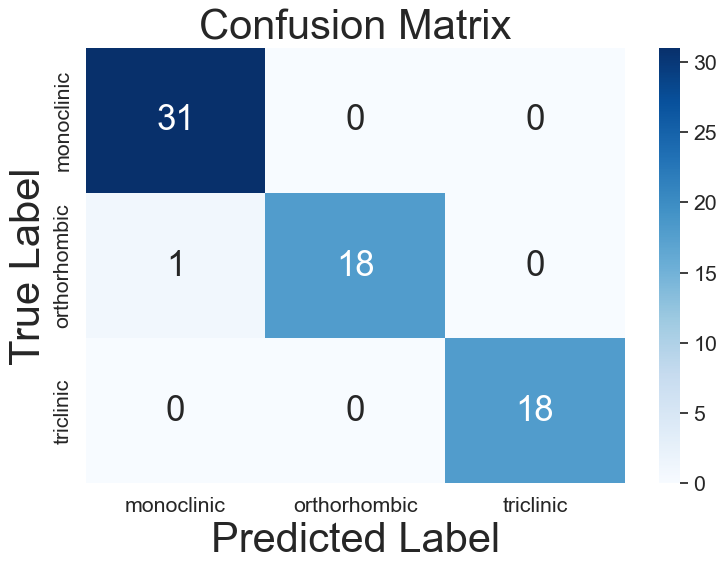

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_labels = label_encoders['Crystal System'].classes_

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Scale all font sizes
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_labels, yticklabels=y_labels, annot_kws={'size': 25})
plt.xlabel("Predicted Label", fontsize=30)
plt.ylabel("True Label", fontsize=30)
plt.title("Confusion Matrix", fontsize=30)
plt.tight_layout()
plt.show()

### Summary

The high accuracy and diagonal dominance on the confusion matrix point to this being an effective model.